In [1]:
# MODIFY! 
# use Robust! 
model_name = 'ElNetRegRobNFE'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/dl-nfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7,.8,.9, .95, .99, 1],max_iter=1000000,cv=10)
model

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [7]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [8]:
model.l1_ratio_

1.0

In [9]:
model.alpha_

0.00586176781913793

In [10]:
hp = pd.Series(name=f'{model_name} HP', data=[model.l1_ratio_, model.alpha_],index=['l1_ratio','alpha'])

In [11]:
hp

l1_ratio    1.000000
alpha       0.005862
Name: ElNetRegRobNFE HP, dtype: float64

In [12]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

# Score Model

In [13]:
# MODIFY!
from sklearn.linear_model import ElasticNet

score_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

score_model

ElasticNet(alpha=0.00586176781913793, l1_ratio=1.0)

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [15]:
scores = pd.DataFrame(scores)

In [16]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.026879,0.005554,-3.229434,-16.372368,-4.046278
1,0.022170,0.002151,-3.174047,-18.715302,-4.326119
2,0.043779,0.001536,-3.355091,-17.396899,-4.170959
3,0.033965,0.001531,-3.225843,-22.619226,-4.755967
4,0.015753,0.001756,-3.276294,-19.473424,-4.412870
5,0.034595,0.001533,-3.433477,-21.641442,-4.652036
6,0.023407,0.001726,-3.284999,-17.189957,-4.146077
7,0.028345,0.001721,-3.299703,-20.018232,-4.474174
8,0.013585,0.001848,-3.352943,-19.773453,-4.446735
9,0.012339,0.001664,-3.588566,-25.309967,-5.030901


In [17]:
mean_scores = scores.mean()

In [18]:
mean_scores

fit_time                             0.025482
score_time                           0.002102
test_neg_mean_absolute_error        -3.322040
test_neg_mean_squared_error        -19.851027
test_neg_root_mean_squared_error    -4.446212
dtype: float64

# Export Model Score

In [19]:
mean_scores = mean_scores.rename(f'{model_name}')

In [20]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [21]:
# mean_scores

In [22]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [23]:
mean_scores

Fit Time       0.025482
Score Time     0.002102
MAE            3.322040
MSE           19.851027
RMSE           4.446212
Name: ElNetRegRobNFE, dtype: float64

In [24]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [25]:
mean_scores

Fit Time       0.025482
Score Time     0.002102
MAE            3.322040
MSE           19.851027
RMSE           4.446212
STD FT         0.010133
STD ST         0.001227
STD MAE        0.119813
STD MSE        2.735367
STD RMSE       0.302266
Name: ElNetRegRobNFE, dtype: float64

In [26]:
mean_scores.to_csv(f'./scores/{model_name}-score.csv')

# Holdout Test

In [27]:
score_model.fit(X_train,y_train)

ElasticNet(alpha=0.00586176781913793, l1_ratio=1.0)

In [28]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

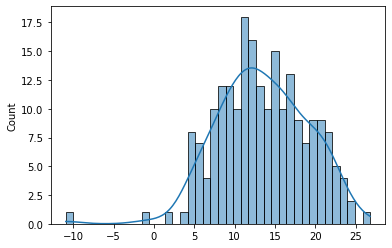

In [29]:
sns.histplot(y_holdout,bins=40,kde=True)

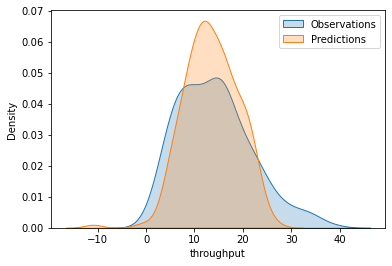

In [30]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

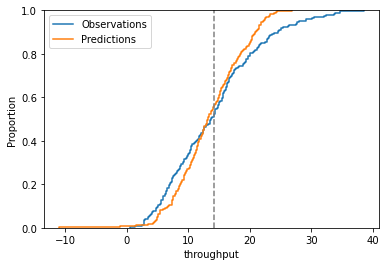

In [31]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [33]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ElNetRegRobNFE
MAE,3.971902
MSE,26.847434
RMSE,5.181451


In [34]:
err_df.to_csv(f'./holdout-test/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [35]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.666697
std      5.150372
min    -12.249025
25%     -2.909981
50%     -0.481829
75%      3.546797
max     18.491834
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

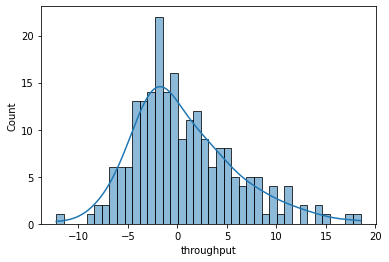

In [36]:
sns.histplot(data=res, kde=True,bins=40)

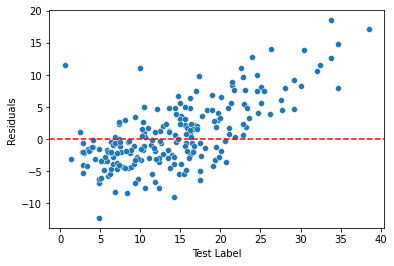

In [37]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

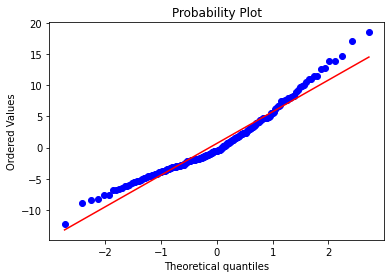

In [38]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [39]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [40]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

ElasticNet(alpha=0.00586176781913793, l1_ratio=1.0)

In [41]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

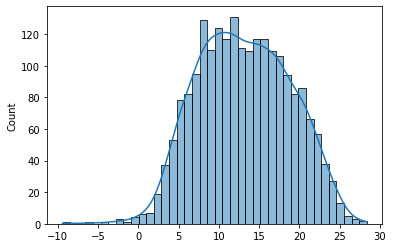

In [42]:
sns.histplot(y_pred,bins=40,kde=True)

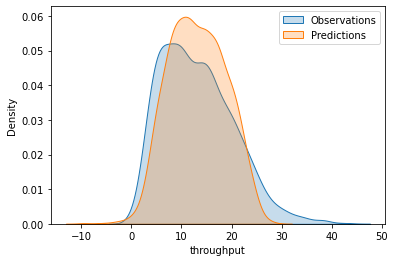

In [43]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

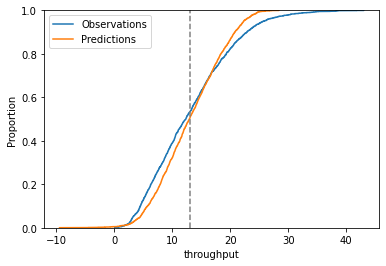

In [44]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [45]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [46]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ElNetRegRobNFE
MAE,3.274754
MSE,18.828382
RMSE,4.339168


In [47]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [48]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/ElNetRegRobNFE-model.joblib']

In [49]:
res = y - y_pred
res.describe().drop('count')

mean    4.148428e-16
std     4.340182e+00
min    -1.632587e+01
25%    -2.884917e+00
50%    -3.155480e-01
75%     2.376921e+00
max     3.562438e+01
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

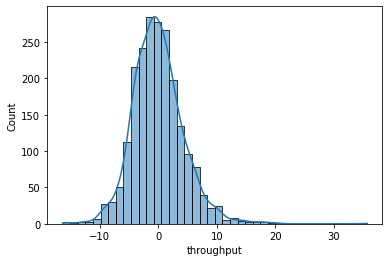

In [50]:
sns.histplot(data=res, kde=True,bins=40)

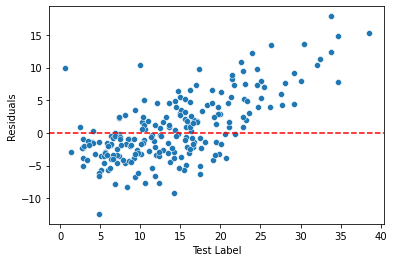

In [51]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

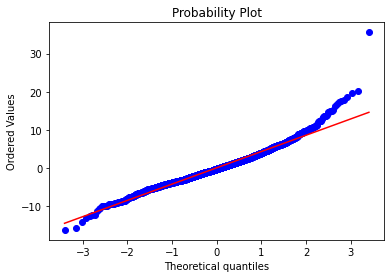

In [52]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!